In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from tokenizers import CustomTokenizer

from tqdm import tqdm
tqdm.pandas() # To use progress_apply and better visualize the progress

/home/guilalire/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df = pd.read_csv('../data/dataset.csv', index_col=0)

## Training Word2Vec

In [3]:
word_tokenizer = CustomTokenizer("word", remove_stopwords=True)
tiktoken_tokenizer = CustomTokenizer(remove_stopwords=True)

### Using NLTK tokenizer

In [4]:
sample_df = df.sample(2000)

In [5]:
X_list = list(sample_df['text'])
X_strings = " ".join(X_list).lower()
X_sents = sent_tokenize(X_strings)
X_sents = [word_tokenize(s) for s in X_sents]

In [6]:
model = Word2Vec(sentences=X_sents, vector_size=50, window=5, min_count=5, workers=4)

word_vectors = model.wv
word_vectors.save("word2vec_nltk.wordvectors") # Store the words and their trained embeddings
del model

In [7]:
wv_nltk = KeyedVectors.load("word2vec_nltk.wordvectors", mmap='r')
wv_nltk.most_similar('france', topn=10)

[('1992', 0.9101343154907227),
 ('italy', 0.9048501253128052),
 ('1980', 0.9036624431610107),
 ('1991', 0.9026995897293091),
 ('germany', 0.9015070199966431),
 ('berlin', 0.9001662731170654),
 ('1997', 0.8918520212173462),
 ('1987', 0.8917990922927856),
 ('moscow', 0.8807260990142822),
 ('1967', 0.8803330659866333)]

### Using Tiktoken

In [8]:
X = df['text']
X_encoded = X.progress_apply(tiktoken_tokenizer.encode)

X_encoded.head()

100%|████████████████████████████████████████████████████████████████████████| 186799/186799 [01:11<00:00, 2601.90it/s]


416     [939, 301, 783, 503, 19950, 330, 2203, 3043, 1...
697     [74, 589, 75314, 305, 2509, 263, 568, 17063, 3...
1168    [73, 986, 20605, 39330, 656, 57572, 31475, 155...
1317    [14724, 5038, 26853, 17370, 320, 42792, 6048, ...
1442    [14172, 569, 12985, 355, 90744, 764, 2886, 199...
Name: text, dtype: object

In [9]:
model = Word2Vec(sentences=X_encoded, vector_size=50, window=5, min_count=5, workers=4)

word_vectors = model.wv
word_vectors.save("word2vec_tiktoken.wordvectors") # Store the words and their trained embeddings
del model

In [10]:
wv_tiktoken = KeyedVectors.load("word2vec_tiktoken.wordvectors", mmap='r')

## Documents embedding using Word2Vec

In [11]:
def document_vector(doc, wv, tokenizer):
    """Create document vectors by averaging word vectors."""
    words = tokenizer.encode(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])
    
    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

## Logistic Regression using Word2Vec

### Using NLTK tokenizer

In [12]:
X = sample_df['text']
y = sample_df['category']

X_vec = np.array([document_vector(text, wv_nltk, word_tokenizer) for text in X])
#X = np.array([document_vector(text, pretrained_wv) for text in X])

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Features dimension: {X_train.shape}")

Features dimension: (1600, 50)


In [13]:
model = LogisticRegression(random_state=42, solver='liblinear', penalty='l2', C=10, max_iter=1000, class_weight='balanced')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

      actors       0.85      0.73      0.79        30
     animals       0.73      0.61      0.67        18
         art       0.47      0.73      0.57        11
       books       0.60      0.79      0.68        19
      events       0.53      0.42      0.47        24
       films       0.79      1.00      0.88        19
     finance       0.37      0.54      0.44        13
        food       0.18      0.08      0.11        24
   geography       0.52      0.79      0.63        14
    industry       0.29      0.27      0.28        15
       music       0.89      0.74      0.81        23
      plants       0.67      0.67      0.67        15
 politicians       0.67      0.59      0.63        27
    politics       0.65      0.50      0.57        26
     science       0.50      0.72      0.59        18
     singers       0.79      0.96      0.87        24
      sports       0.64      0.74      0.68        19
 vi

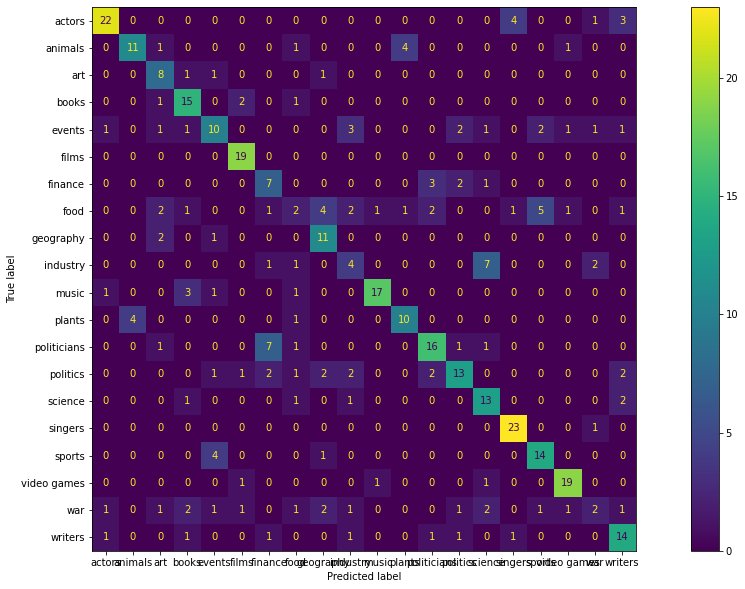

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(20, 10))
disp.plot(ax=ax)
plt.show()

### Using Tiktoken

In [15]:
X = df['text']
y = df['category']

X_vec = np.array([document_vector(text, wv_tiktoken, tiktoken_tokenizer) for text in X])
#X = np.array([document_vector(text, pretrained_wv) for text in X])

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Features dimension: {X_train.shape}")

Features dimension: (149439, 50)


In [16]:
model = LogisticRegression(random_state=42, solver='lbfgs', penalty='l2', C=1, max_iter=1000, class_weight='balanced')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

      actors       0.76      0.79      0.77      1973
     animals       0.88      0.82      0.85      1970
         art       0.86      0.90      0.88      1479
       books       0.79      0.81      0.80      2025
      events       0.65      0.59      0.62      1989
       films       0.88      0.95      0.91      1947
     finance       0.46      0.66      0.54       788
        food       0.65      0.51      0.57      2025
   geography       0.71      0.74      0.73      2011
    industry       0.49      0.56      0.53      1108
       music       0.93      0.94      0.94      2046
      plants       0.90      0.89      0.89      2067
 politicians       0.67      0.72      0.70      1950
    politics       0.59      0.55      0.57      1963
     science       0.87      0.85      0.86      2074
     singers       0.78      0.86      0.82      2020
      sports       0.65      0.71      0.68      1973
 vi

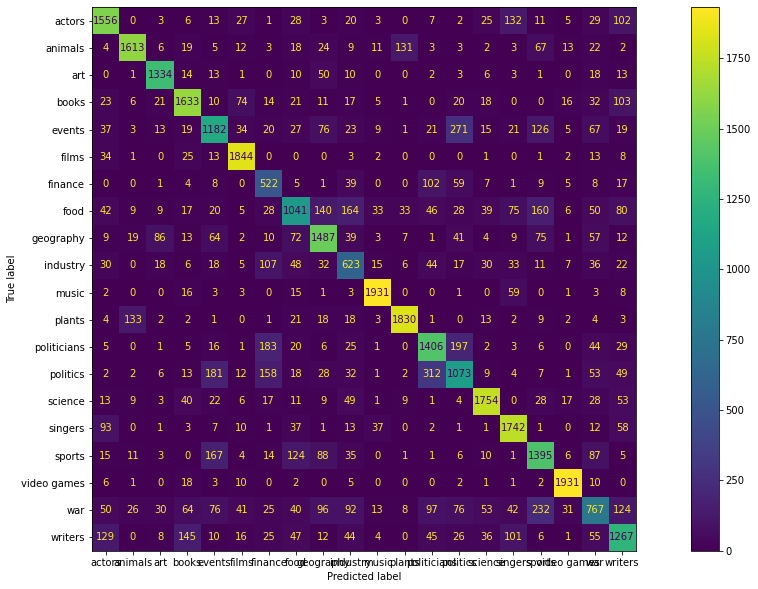

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(20, 10))
disp.plot(ax=ax)
plt.show()

## Logistic Regression using TF-IDF

### Using NLTK tokenizer

In [18]:
X = sample_df['text']
y = sample_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [19]:
model = make_pipeline(CountVectorizer(tokenizer=word_tokenizer.encode, ngram_range=(1,1)),
                      TfidfTransformer(),
                      LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', penalty='l1', C=100, max_iter=1000))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

      actors       0.93      0.90      0.92        30
     animals       0.94      0.83      0.88        18
         art       0.92      1.00      0.96        11
       books       0.77      0.89      0.83        19
      events       0.65      0.71      0.68        24
       films       0.79      1.00      0.88        19
     finance       1.00      0.85      0.92        13
        food       0.89      0.67      0.76        24
   geography       0.80      0.86      0.83        14
    industry       0.67      0.53      0.59        15
       music       0.92      0.96      0.94        23
      plants       0.88      1.00      0.94        15
 politicians       0.75      0.67      0.71        27
    politics       0.76      0.73      0.75        26
     science       0.60      0.83      0.70        18
     singers       0.86      1.00      0.92        24
      sports       0.78      0.74      0.76        19
 vi

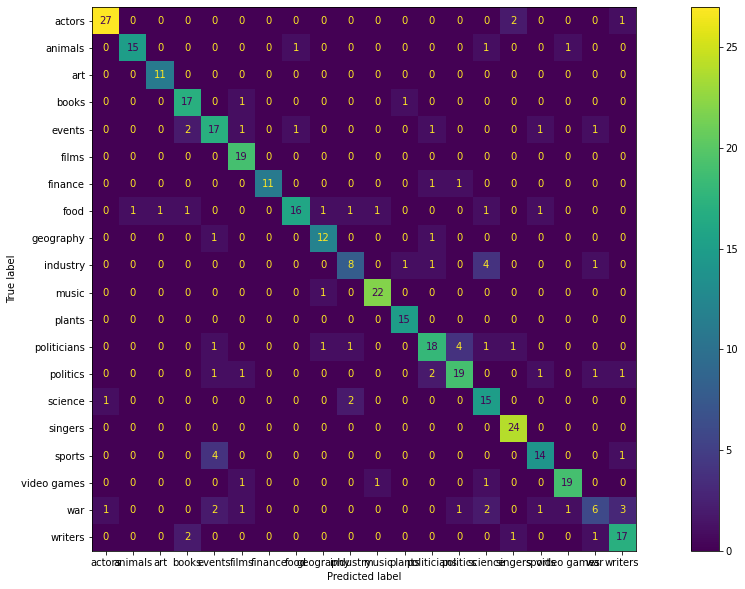

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(20, 10))
disp.plot(ax=ax)
plt.show()

### Using Tiktoken

In [21]:
X = df['text']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [22]:
model = make_pipeline(CountVectorizer(tokenizer=tiktoken_tokenizer.encode, ngram_range=(1,1)),
                      TfidfTransformer(),
                      LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', penalty='l1', C=10, max_iter=1000))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

      actors       0.96      0.94      0.95      1973
     animals       0.96      0.94      0.95      1970
         art       0.97      0.96      0.97      1479
       books       0.92      0.92      0.92      2025
      events       0.85      0.88      0.86      1989
       films       0.94      0.97      0.96      1947
     finance       0.82      0.81      0.82       788
        food       0.90      0.86      0.88      2025
   geography       0.92      0.91      0.91      2011
    industry       0.77      0.72      0.75      1108
       music       0.97      0.98      0.98      2046
      plants       0.98      0.97      0.98      2067
 politicians       0.81      0.84      0.83      1950
    politics       0.78      0.77      0.77      1963
     science       0.92      0.91      0.91      2074
     singers       0.93      0.95      0.94      2020
      sports       0.83      0.89      0.86      1973
 vi

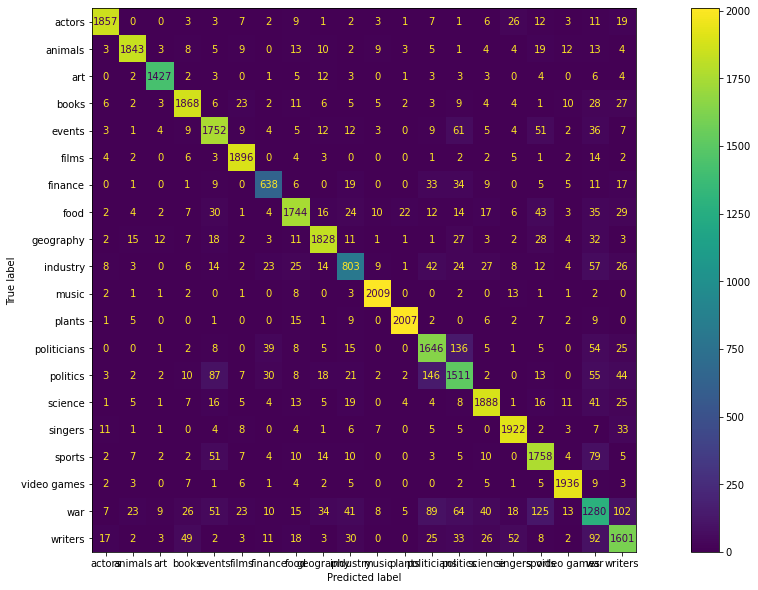

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(20, 10))
disp.plot(ax=ax)
plt.show()

## GridSearch to find the best hyperparameters for Logistic Regression using Word2Vec

In [24]:
sample_df = df.sample(5000)
X = sample_df['text']
y = sample_df['category']

X = np.array([document_vector(text, wv_tiktoken, tiktoken_tokenizer) for text in X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

In [25]:
param_grid = [
    {'solver': ['liblinear'],
      'penalty': ['l1', 'l2'],
      'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'solver': ['lbfgs'],
      'penalty': ['l2'],
      'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    ]

grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score:", test_score)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/guilalire/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/guilalire/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score: 0.71725
Test set score: 0.711


In [26]:
results = pd.DataFrame(grid_search.cv_results_)
params_df = pd.DataFrame(results['params'].tolist())
scores = pd.concat([params_df, results['mean_test_score']], axis=1)
scores.sort_values(by='mean_test_score', ascending=False)

,C,penalty,solver,mean_test_score
14,0.100,l2,lbfgs,0.71725
15,1.000,l2,lbfgs,0.71600
7,1.000,l2,liblinear,0.71100
6,1.000,l1,liblinear,0.70925
8,10.000,l1,liblinear,0.70750
5,0.100,l2,liblinear,0.70650
9,10.000,l2,liblinear,0.70625
11,100.000,l2,liblinear,0.70550
10,100.000,l1,liblinear,0.70300
16,10.000,l2,lbfgs,0.70275


## GridSearch to find the best hyperparameters for Logistic Regression using TF-IDF

In [27]:
sample_df = df.sample(5000)
X = sample_df['text']
y = sample_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = make_pipeline(CountVectorizer(tokenizer=word_tokenizer.encode, ngram_range=(1,1)),
                      TfidfTransformer(),
                      LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))

In [ ]:
param_grid = [
    {'logisticregression__solver': ['liblinear'],
      'logisticregression__penalty': ['l1', 'l2'],
      'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'logisticregression__solver': ['lbfgs'],
      'logisticregression__penalty': ['l2'],
      'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
    ]

grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score:", test_score)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/guilalire/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
params_df = pd.DataFrame(results['params'].tolist())
scores = pd.concat([params_df, results['mean_test_score']], axis=1)
scores.sort_values(by='mean_test_score', ascending=False)